# Last saturation altitude  

<img src="Figs/lastsaturation.svg" width="500" height="300">

** Aim: ** We want to show that the relative humidity of an air parcel in the troposphere can be predicted by the altitude at which it was last saturated. As a first approximation, we could consider the closest cloud above the tropospheric parcel, beign at altitude $z_{cloud}$. Supposing last saturation of tropospheric parcel occured at $z_{cloud}$, we can predict the relative humidity at parcel altitude as follows 
$$
RH_{predicted} = \frac{q_{sat}(z_{cloud})}{q_{sat}(z_{parcel})}
$$
This can easily be compared to the actual humidity at parcel altitude 
$$
RH_{actual} = \frac{q_{v}(z_{parcel})}{q_{sat}(z_{parcel})}
$$

where $q_i$ is the mixing ratio of atmospheric component $i$. It measures the amount of component $i$ in a given air mass, so it is given in g/kg (grams of $i$ per kilogram of air)

- $q_v$ = vapour  
- $q_r$ = rain  
- $q_c$ = cloud  
- $q_i$ = ice  
- $q_s$ = snow  
- $q_g$ = gropel   
- $q_{vm\phi}$ = dq/dt microphysics: distinguer condensation/évaporation  

We proceed in several steps to achieve our aim:

- Step 1: Determine the closest cloud altitude above a parcel located in the troposphere (~5km), for every grid point.  
- Step 2: Calculate the *actual* relative humidity at $z_{parcel}$ using $q_{v}(z_{parcel})$   
- Step 3: Compute the *predicted* relative humidity at $z_{parcel}$ using $q_{sat}(z_{cloud})$
- Step 4: Compare the distributions obtained in steps 2 & 3 to assess the assumption  
- Step 5: With simulations having smaller timesteps, take into account atmospheric subsidence to calculate a better $z_{clouds}$

## Importing data and libraries, read data

As shown below different datasets are indexed as follows:  

| Index          | Simulation     | 
| :------------- | :----------:   | 
|    no index    |  SAMUW_rceiso_96km_30C_750m_3Dmphyfull.nc                  |  
|        2       | $~~~~~~$SAMUW_rceiso_96km_30C_750m_m60hPad_3Dmphyfull.nc   |  
|        3       | SAMUW_rceiso_cyclone_3D.nc                                 |
|        4       | SAMUW_rceiso_cyclone_m60hPad_3D.nc                         |
|        5       | rceiso_squall2_U10_H1000_2km_rceiso01_3D.nc                |
|        6       | SAMUW_rceiso_squall2_U10_H1000_m60hPad_3D.nc               |

In [80]:
import os
from numba import njit,jit
import numpy as np

import seaborn as sns
sns.set(color_codes=True)
sns.set_palette(sns.color_palette("Paired")+['#D3D3D3','#808080'])

import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams
import matplotlib.colors
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 0.2 #set the value globally
mpl.rcParams['xtick.major.width'] = 0.3
mpl.rcParams['xtick.minor.width'] = 0.3
mpl.rcParams['ytick.major.width'] = 0.3
mpl.rcParams['ytick.minor.width'] = 0.3

from netCDF4 import Dataset
import scipy.stats as sp
import adsfunc as ads

fpath = os.path.join(rcParams["datapath"], "/Users/felixlangot/Library/Fonts/Cronos-Pro-Light_12448.ttf")
Csprop = fm.FontProperties(fname=fpath)
Cstitleprop = Csprop.copy()
Cslabelprop = Csprop.copy()
Cstitleprop.set_size(30)
Csprop.set_size(25)
Cslabelprop.set_size(25)

fpath2 = os.path.join(rcParams["datapath"], "/Users/felixlangot/Library/Fonts/MinionPro-Regular.otf")
Mpprop = fm.FontProperties(fname=fpath2)
Mptitleprop = Mpprop.copy()
Mplabelprop = Mpprop.copy()
Mptitleprop.set_size(30)
Mpprop.set_size(25)
Mplabelprop.set_size(15)

fpath3 = os.path.join(rcParams["datapath"], "/Users/felixlangot/Library/Fonts/texgyrepagella-math.otf")
Tgprop = fm.FontProperties(fname=fpath3)
Tgtitleprop = Tgprop.copy()
Tglabelprop = Tgprop.copy()
Tgtitleprop.set_size(30)
Tgprop.set_size(25)
Tglabelprop.set_size(15)

In [2]:
data = Dataset('NetCDF/SAMUW_rceiso_96km_30C_750m_3Dmphyfull.nc')
data2 = Dataset('NetCDF/SAMUW_rceiso_96km_30C_750m_m60hPad_3Dmphyfull.nc')
data3 = Dataset('NetCDF/SAMUW_rceiso_cyclone_3D.nc')
data4 = Dataset('NetCDF/SAMUW_rceiso_cyclone_m60hPad_3D.nc')
#data5 = Dataset('NetCDF/SAMUW_rceiso_squall2_U10_H1000_2km_3D.nc')
data5 = Dataset('NetCDF/rceiso_squall2_U10_H1000_2km_rceiso01_3D.nc')
data6 = Dataset('NetCDF/SAMUW_rceiso_squall2_U10_H1000_m60hPad_3D.nc')
print("data:")
print(data)
qc = data.variables['QC'][:]
qi = data.variables['QI'][:]
qsat = data.variables['QSAT'][:]
qv = data.variables['QV'][:]
x = np.asarray(data.variables['x'][:])
y = np.asarray(data.variables['y'][:])
z = np.asarray(data.variables['z'][:])
t = data.variables['time'][:]
t = t - 50

qc2 = data2.variables['QC'][:]
qi2 = data2.variables['QI'][:]
qsat2 = data2.variables['QSAT'][:]
qv2 = data2.variables['QV'][:]
x2 = np.asarray(data2.variables['x'][:])
y2 = np.asarray(data2.variables['y'][:])
z2 = np.asarray(data2.variables['z'][:])
t2 = data2.variables['time'][:]
t2 = t2 - 50

qc3 = data3.variables['QC'][:]
qi3 = data3.variables['QI'][:]
qsat3 = data3.variables['QSAT'][:]
qv3 = data3.variables['QV'][:]
x3 = np.asarray(data3.variables['x'][:])
y3 = np.asarray(data3.variables['y'][:])
z3 = np.asarray(data3.variables['z'][:])
t3 = data3.variables['time'][:]
t3 = t3 - 45

qc4 = data4.variables['QC'][:]
qi4 = data4.variables['QI'][:]
qsat4 = data4.variables['QSAT'][:]
qv4 = data4.variables['QV'][:]
x4 = np.asarray(data4.variables['x'][:])
y4 = np.asarray(data4.variables['y'][:])
z4 = np.asarray(data4.variables['z'][:])
t4 = data4.variables['time'][:]
t4 = t4 - 40

qc5 = data5.variables['QC'][:]
qi5 = data5.variables['QI'][:]
qsat5 = data5.variables['QSAT'][:]
qv5 = data5.variables['QV'][:]
x5 = np.asarray(data5.variables['x'][:])
y5 = np.asarray(data5.variables['y'][:])
z5 = np.asarray(data5.variables['z'][:])
t5 = data5.variables['time'][:]
t5 = t5 - 41

qc6 = data6.variables['QC'][:]
qi6 = data6.variables['QI'][:]
qsat6 = data6.variables['QSAT'][:]
qv6 = data6.variables['QV'][:]
x6 = np.asarray(data6.variables['x'][:])
y6 = np.asarray(data6.variables['y'][:])
z6 = np.asarray(data6.variables['z'][:])
t6 = data6.variables['time'][:]
t6 = t6 - 41

print( "qc: ", data.variables['QC'],
       "qi: ", data.variables['QI'],
       "z: ", data.variables['z'],    )
print(t,t2,t3,t4,t5,t6)

data:
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    history: Sun Jun 14 13:55:07 2020: ncks -v x,y,z,p,W,TABS,QV,HDOV,O18V,QR,HDOR,O18R,QG,HDOG,O18G,QS,HDOS,O18S,QC,HDOC,O18C,QI,HDOI,O18I,QVMPHY,QRMPHY,QSAT,HDOVMPHY,O18VMPHY,HDORMPHY,O18RMPHY,HDOVak,O18Vak -d z,1,68 tmp.nc inputs/SAMUW_rceiso_96km_30C_750m_3Dmphyfull.nc
Sun Jun 14 13:54:59 2020: ncrcat /ccc/store/cont003/gen7632/risicami/SAMUW_rceiso_96km_30C_750m/rceiso_rceiso01_64_0000432000.nc /ccc/store/cont003/gen7632/risicami/SAMUW_rceiso_96km_30C_750m/rceiso_rceiso01_64_0000440640.nc /ccc/store/cont003/gen7632/risicami/SAMUW_rceiso_96km_30C_750m/rceiso_rceiso01_64_0000449280.nc /ccc/store/cont003/gen7632/risicami/SAMUW_rceiso_96km_30C_750m/rceiso_rceiso01_64_0000457920.nc /ccc/store/cont003/gen7632/risicami/SAMUW_rceiso_96km_30C_750m/rceiso_rceiso01_64_0000466560.nc /ccc/store/cont003/gen7632/risicami/SAMUW_rceiso_96km_30C_750m/rceiso_rceiso01_64_0000475200.nc /ccc/store/con

In [61]:
print(data.variables['QV'])

<class 'netCDF4._netCDF4.Variable'>
float32 QV(time, z, y, x)
    long_name: Water Vapor                                                                     
    units: g/kg      
unlimited dimensions: time
current shape = (10, 68, 128, 128)
filling on, default _FillValue of 9.969209968386869e+36 used
<ipython-input-61-32c1eebfece5>:1: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  print(data.variables['QV'])


# Step 1: Finding the altitude of closest clouds above the troposhpere  
For now we focus on dataset 'SAMUW_rceiso_96km_30C_750m_3Dmphyfull' and figure out how to perform ** Step 1 ** for those data.
## Find index of altitude 5km
The first thing we want to know is where the troposphere is in the z array, i.e., at which array index izparcel altitude zparcel is   

In [3]:
i = 0
while z[i] <= max(z):
    if z[i] >= 5000:
        zparcel = z[i]
        izparcel = i
        break
    i+=1
print("index of zparcel: ", izparcel, ", zparcel = ", zparcel)

index of zparcel:  23 , zparcel =  5077.64


## 2D maps of cloud ice mixing ratio $q_i$ and cloud water mixing ratio $q_c$

Clouds are detected by computing the sum of ice mixing ratio $q_i$ and water mixing ratio $q_c$, which correspond to the amount of ice/water contained in a certain air mass. By setting a threshold $\texttt{thresh} = 1 \times 10^{-6}$ g/kg (Risi et. al. 2021) we sort the ($x,y,z$) locations as being part of clouds or environment in each dataset.

In [4]:
# QImap = plt.pcolormesh(qi[0,:,:,izparcel], cmap="Blues_r")
# cb = plt.colorbar(QImap)
# cb.set_label("$q_i$ (g/kg)")
# plt.show()
# QCmap = plt.pcolormesh(qc[0,:,:,izparcel], cmap="Blues_r")
# cb = plt.colorbar(QCmap)
# cb.set_label("$q_c$ (g/kg)")
# plt.show()

## First cloud above parcel detection (1D)

As previously stated, presence of clouds is detected by the quantity $q_c + q_i$ reaching a threshold of $1\times10^{-6}$ g/kg. Above a particular coordinate (x,y), the closest cloud altitude $z_{cloud}$ can be detected as following:

In [5]:
zcloud = 0
thresh = 1e-6
cond = qc[0,izparcel:,0,0]+qi[0,izparcel:,0,0]
if np.max(cond) - thresh >= 0:
    zcloud = z[np.min(np.where(cond-thresh>=0))] + zparcel
else:
    zcloud = np.max(z)
print("zcloud = ", zcloud)

zcloud =  8127.3604


## First cloud above parcel detection (2D)  
Using the same method, we now find all closest clouds along the $x$-axis

In [6]:
xclouds = np.zeros(len(x))
zclouds = np.zeros(len(x))
thresh = 1e-6
k = izparcel
for i in np.arange(len(x)):
    xclouds[i] = i
    cond = qc[0,izparcel:,0,i]+qi[0,izparcel:,0,i]
    if np.max(cond) - thresh >= 0:
        zclouds[i] = z[np.min(np.where(cond-thresh>=0))] + zparcel
    else:
        zclouds[i] = np.max(z)



### 2D plot result

Cloud base altitude is given along the $x$-axis . Parcel altitude is shown by the red line 

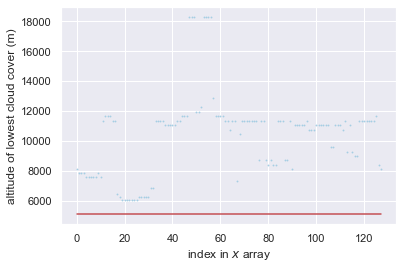

In [7]:
plt.plot(xclouds, np.ones((len(zclouds)))*zparcel, color="r")
plt.scatter(xclouds, zclouds, s=0.7)
plt.xlabel('index in $x$ array')
plt.ylabel('altitude of lowest cloud cover (m)')
plt.show()

## Detection of first cloud above parcel  (3D)  


In [64]:
zclouds = np.zeros((len(t),len(x),len(y)))
thresh = 1e-6
for time in np.arange(len(t)):
    for i in np.arange(len(x)):
        for j in np.arange(len(y)):
            cond = qc[time,izparcel:,j,i]+qi[time,izparcel:,j,i]
            if np.max(cond) - thresh >= 0:
                zclouds[time,i,j] = z[izparcel+np.min(np.where(cond-thresh>=0))]
            else:
                zclouds[time,i,j] = np.max(z)

### Plot of the result

$z_{clouds}$ is the altitude in meters above the tropospheric parcel ($z_{parcel} \approx$ 5000 m) at which the first cloud is encountered. Following the 2D approach, values of $z = z_{max} \approx$ 18 000 m are given to grid points with no cloud cover.  
Therefore white regions show cloud cover close to the troposphere while blue regions show higher or no cloud cover. 

<ipython-input-81-99f5879d740b>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  Cloudmap = plt.pcolormesh(x/1000, y/1000, zclouds[2,:,:]/1000, cmap="Blues")


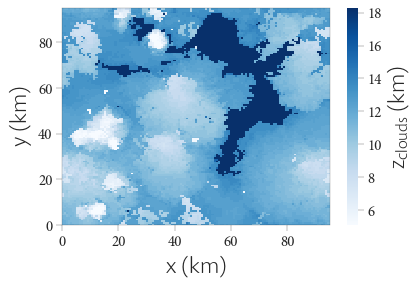

In [81]:
with sns.axes_style("ticks"):
    Cloudmap = plt.pcolormesh(x/1000, y/1000, zclouds[2,:,:]/1000, cmap="Blues")
    plt.xlabel("$\mathdefault{x}$ (km)", fontproperties=Cslabelprop)
    plt.ylabel("$\mathdefault{y}$ (km)", fontproperties=Cslabelprop)
    cb = plt.colorbar(Cloudmap)
    cb.set_label('$z_{clouds}$ (km)')
    cb.set_label(r'$\mathdefault{z_{clouds}}$ (km)', font=Cslabelprop)
    cb.outline.set_visible(False)
    for l in cb.ax.yaxis.get_ticklabels():
        l.set_family("Minion Pro")
        l.set_size(15)
    plt.xticks(font = Mplabelprop)
    plt.yticks(font = Mplabelprop)
    plt.savefig('Figs/3Dclouds.png', bbox_inches='tight', format='PNG', dpi=600)
    plt.show()

# Pdf of $z_{cloud}$ above 5km

We are now interested in finding the distribution of relative humidity throughout the 3D domain. We therefore neglect the spatial and temporal distribution of $RH$ and $z_{clouds}$. First we look at the the $z_{clouds}$ distribution. We choose somewhat arbitrarily the number of bins to be 30 throughout every histogram calculation.

In [10]:
nbins = 30
zparcel

5077.64

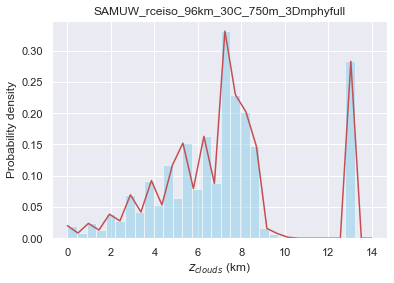

In [11]:
zzclouds = zclouds.flatten()
hist = np.histogram(zzclouds/1000-zparcel/1000, density=True, bins=30)
plt.hist(zzclouds/1000-zparcel/1000, rasterized=True, color='skyblue', density=True, bins=nbins, alpha=0.5)
distrib = sp.rv_histogram(hist)
xaxis = np.linspace(0,14,30)
plt.plot(xaxis, distrib.pdf(xaxis), color='r')
plt.title('SAMUW_rceiso_96km_30C_750m_3Dmphyfull')
plt.xlabel('$z_{clouds}$ (km)')
plt.ylabel('Probability density')
plt.show()

# Step 2: Calculate the *actual* RH at 5km
*Reminder* The actual relative humidity in the troposphere is the ratio of vapour mixing ratio $q_v$ over the saturation mixing ratio $q_{sat]}$:
$$
RH = q_v/q_{sat}
$$
*Data info*

In [12]:
print('qsat: ', data.variables['QSAT'], 'qv: ', data.variables['QV'])

qsat:  <class 'netCDF4._netCDF4.Variable'>
float32 QSAT(time, z, y, x)
    long_name: Saturation specific humidity                                                    
    units: g/kg      
unlimited dimensions: time
current shape = (10, 68, 128, 128)
filling on, default _FillValue of 9.969209968386869e+36 used qv:  <class 'netCDF4._netCDF4.Variable'>
float32 QV(time, z, y, x)
    long_name: Water Vapor                                                                     
    units: g/kg      
unlimited dimensions: time
current shape = (10, 68, 128, 128)
filling on, default _FillValue of 9.969209968386869e+36 used
<ipython-input-12-69fa479ee26c>:1: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  print('qsat: ', data.variables['QSAT'], 'qv: ', data.variables['QV'])


### RH loop  

We calculate the relative humidity at parcel altitude $\texttt{rh}$ by looping over time and grid axes. Theres is an added $\texttt{if}$ statement here because units of $q_v$ and $q_{sat}$ are not always well input. This essentially prevents $\texttt{rh} > 1$. Note that there are still some grid points with $\texttt{rh}$ slightly superior to 1 due to oversaturation in ice clouds.

In [13]:
rh = np.zeros((len(t),len(x),len(y)))
for time in np.arange(len(t)):
        for i in np.arange(len(x)):
            for j in np.arange(len(y)):
                if 100 < qv[time,izparcel,j,i]/qsat[time,izparcel,j,i]:
                    rh[time,i,j] = (qv[time,izparcel,j,i]/qsat[time,izparcel,j,i])/1000
                else:
                    rh[time,i,j] = (qv[time,izparcel,j,i]/qsat[time,izparcel,j,i])

maxindex = np.unravel_index(rh.argmax(), rh.shape)
print(maxindex)
print(rh[ maxindex[0], maxindex[1], maxindex[2] ])

(5, 53, 106)
1.0592001676559448


### Plot of RH pdf for the first simulation

The pdf (in red) is plotted over the data histogram

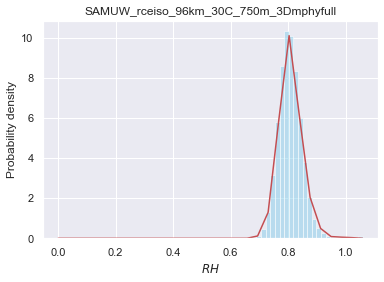

In [14]:
Rh = rh.flatten()
hist = np.histogram(Rh, density=True, bins=30)
plt.hist(Rh, color='skyblue', density=True, bins=30, alpha=0.5)
distrib = sp.rv_histogram(hist)
xaxis = np.linspace(0,np.max(Rh),30)
plt.plot(xaxis, distrib.pdf(xaxis), color='r')
plt.xlabel('$RH$')
plt.ylabel('Probability density')
plt.title('SAMUW_rceiso_96km_30C_750m_3Dmphyfull')
plt.show()

# Other datasets  

To perform the same analysis on other datasets, we define functions for each looping process (e.g. last saturation altitude detection LSA(T,X,Y,Z,QI,QC)) that allow to perform the same calculations done previously. To speedup the code, the functions are compiled using Numba ([See documentation](https://numba.pydata.org/))

### Functions   
- $\texttt{Zparcel(Z)}$: Determines altitude and array index of the tropospheric air parcel  
- $\texttt{LSA(T,X,Y,Z,QI,QC,QSAT)}$: Determines altitude of closest cloud above parcel $(z_{clouds})$ and appends the value of $q_{sat}$ there. Also returns the index of $z_{clouds}$.
- $\texttt{RELHUM(T,X,Y,Z,QV,QSAT)}$: Computes the actual relative humidity at the troposphere.
- $\texttt{RELHUMP(T,X,Y,Z,QSAT,iZclouds)}$: Computes the predicted relative humidity at the troposphere.

In [15]:
@njit
def Zparcel(Z):
    i = 0
    while Z[i] <= max(Z):
        if Z[i] >= 5000:
            Zparcel = Z[i]
            iZparcel = i
            break
        i+=1
    return iZparcel, Zparcel
@njit
def LSA(T,X,Y,Z,QI,QC,QSAT):
    zclouds = np.zeros( ( len(T),len(X),len(Y) ) )
    izclouds = np.zeros( ( len(T),len(X),len(Y) ) )
    qsatzclouds = np.zeros( ( len(T),len(X),len(Y) ) )
    thresh = 1e-6
    for time in np.arange(len(T)):
        for i in np.arange(len(X)):
            for j in np.arange(len(Y)):
                cond = QC[time,Zparcel(Z)[0]:,j,i]+QI[time,Zparcel(Z)[0]:,j,i]
                if np.max(cond) - thresh >= 0:
                    toto = np.where(cond-thresh>=0)
                    (matrix,) = toto
                    zclouds[time,i,j] = Z[Zparcel(Z)[0]+np.min(matrix)]
                    izclouds[time,i,j] = int(Zparcel(Z)[0]+np.min(matrix))
                    qsatzclouds[time,i,j] = QSAT[time,Zparcel(Z)[0]+np.min(matrix),j,i]
                    if qsatzclouds[time,i,j] > 100:
                        qsatzclouds[time,i,j] = qsatzclouds[time,i,j]/1000
                else:
                    zclouds[time,i,j] = np.max(Z)
                    izclouds[time,i,j] = int(np.argmax(Z))
                    qsatzclouds[time,i,j] = QSAT[time,np.argmax(Z),j,i]
                    if qsatzclouds[time,i,j] > 100:
                        qsatzclouds[time,i,j] = qsatzclouds[time,i,j]/1000
    return zclouds, izclouds, qsatzclouds

In [16]:
zlist = np.asarray([z,z2,z3,z4,z5,z6])
izparcelist = np.zeros((6))
zparcelist = np.zeros((6))
for i in np.arange(len(zparcelist)):
    izparcelist[i] = Zparcel(zlist[i])[0]
    zparcelist[i] = Zparcel(zlist[i])[1]

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### Last saturation altitude  
We calculate the altitude of closest cloud above parcel at each time step for all grid points and every dataset.

In [17]:
lsa = LSA(t,x,y,z,qi,qc,qsat)
lsa2 = LSA(t2,x2,y2,z2,qi2,qc2,qsat2)
lsa3 = LSA(t3,x3,y3,z3,qi3,qc3,qsat3)
lsa4 = LSA(t4,x4,y4,z4,qi4,qc4,qsat4)
lsa5 = LSA(t5,x5,y5,z5,qi5,qc5,qsat5)
lsa6 = LSA(t6,x6,y6,z6,qi6,qc6,qsat6)

Since $\texttt{LSA(T,X,Y,Z,QI,QC,QSAT)}$ has several outputs, we need to associate the right input to the altitude of the closest cloud above each grid point for each simulation, as is done in the next cell.

In [18]:
zclouds = lsa[0].flatten()
zclouds2 = lsa2[0].flatten()
zclouds3 = lsa3[0].flatten()
zclouds4 = lsa4[0].flatten()
zclouds5 = lsa5[0].flatten()
zclouds6 = lsa6[0].flatten()

We then make a list of all these outputs and one with the associated simulation names

In [19]:
zcloudslist = np.array([[zclouds, zclouds2, zclouds3], [zclouds4, zclouds5, zclouds6]], dtype=object)
zparcelist = np.reshape(zparcelist, (2,3))
plotlabelslist = np.asarray([['SAMUW_rceiso_96km_30C_750m_3Dmphyfull','SAMUW_rceiso_96km_30C_750m_m60hPad_3Dmphyfull', 'SAMUW_rceiso_cyclone_3D'], ['SAMUW_rceiso_cyclone_m60hPad_3D', 'rceiso_squall2_U10_H1000_2km_rceiso01_3D', 'SAMUW_rceiso_squall2_U10_H1000_m60hPad_3D']], dtype=object)

The next cell plots all results together in one figure.

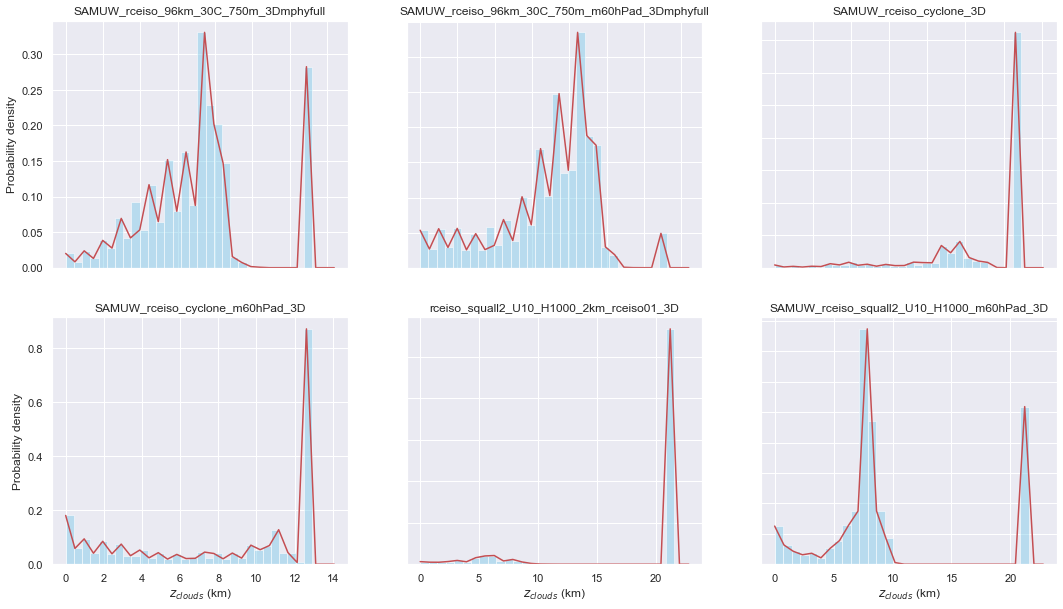

In [20]:
fig, ax = plt.subplots(2,3,figsize=(18,10))
for i in np.arange(len(zcloudslist[:,0])):
    for j in np.arange(len(zcloudslist[0,:])):
        zcloudshist = np.asarray(np.histogram(zcloudslist[i,j]/1000-zparcelist[i,j]/1000, density=True, bins=nbins), dtype=object)
        zcloudsdistrib = sp.rv_histogram(zcloudshist)
        zcloudsxaxis = np.linspace(0, np.max(zcloudslist[i,j]/1000)-0.77*(zparcelist[i,j]/1000), nbins)
        ax[i,j].plot(zcloudsxaxis, zcloudsdistrib.pdf(zcloudsxaxis), color='r')
        ax[i,j].hist(zcloudslist[i,j]/1000-zparcelist[i,j]/1000, rasterized=True, color='skyblue', density=True, bins=nbins, alpha = 0.5)
        ax[i,j].set_title(plotlabelslist[i,j])
        ax[i,j].set_xlabel('$z_{clouds}$ (km)')
        ax[i,j].set_ylabel('Probability density')
for axi in ax.flat:
    axi.label_outer()
plt.savefig('Figs/zclouds_pdf.png' , format='PNG', dpi=600)
plt.show()

### Actual relative humidity at 5km  

Here the same process is repeated for the actual relative humidity

In [21]:
@njit
def RELHUM(T,X,Y,Z,QV,QSAT):
    RH = np.zeros( (len(T),len(X),len(Y)) )
    for time in np.arange(len(T)):
        for i in np.arange(len(X)):
            for j in np.arange(len(Y)):
                if 100 < QV[time,Zparcel(Z)[0],j,i]/QSAT[time,Zparcel(Z)[0],j,i]:
                    RH[time,i,j] = (QV[time,Zparcel(Z)[0],j,i]/QSAT[time,Zparcel(Z)[0],j,i])/1000
                else:
                    RH[time,i,j] = (QV[time,Zparcel(Z)[0],j,i]/QSAT[time,Zparcel(Z)[0],j,i])
        
    return RH

In [22]:
RH = RELHUM(t,x,y,z,qv,qsat)
RH2 = RELHUM(t2,x2,y2,z2,qv2,qsat2)
RH3 = RELHUM(t3,x3,y3,z3,qv3,qsat3)
RH4 = RELHUM(t4,x4,y4,z4,qv4,qsat4)
RH5 = RELHUM(t5,x5,y5,z5,qv5,qsat5)
RH6 = RELHUM(t6,x6,y6,z6,qv6,qsat6)

In [23]:
Rh = RH.flatten()
Rh2 = RH2.flatten()
Rh3 = RH3.flatten()
Rh4 = RH4.flatten()
Rh5 = RH5.flatten()
Rh6 = RH6.flatten()

In [24]:
%store Rh

Stored 'Rh' (ndarray)


In [25]:
Rhlist = np.array([[Rh,Rh2, Rh3],[Rh4, Rh5, Rh6]])

<ipython-input-25-dad2699e5ecc>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Rhlist = np.array([[Rh,Rh2, Rh3],[Rh4, Rh5, Rh6]])


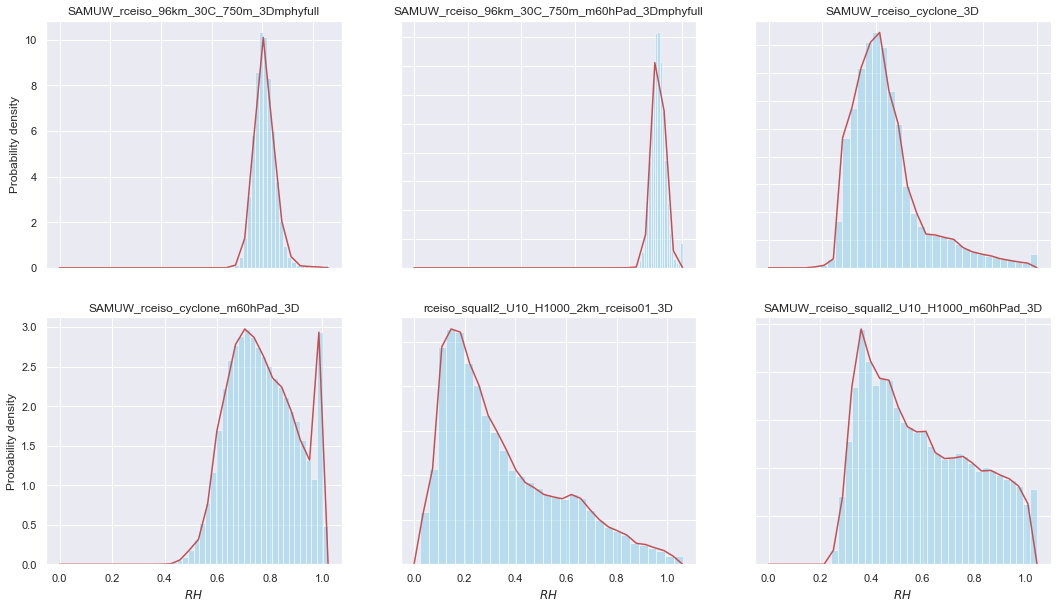

In [26]:
fig, ax = plt.subplots(2,3,figsize=(18,10))
for i in np.arange(len(Rhlist[:,0])):
    for j in np.arange(len(Rhlist[0,:])):
        Rhhist = np.asarray(np.histogram(Rhlist[i,j], density=True, bins=nbins), dtype=object)
        Rhdistrib = sp.rv_histogram(Rhhist)
        Rhxaxis = np.linspace(0,np.max(Rhlist[i,j]),nbins)
        ax[i,j].plot(Rhxaxis, Rhdistrib.pdf(Rhxaxis), color='r')
        ax[i,j].hist(Rhlist[i,j], rasterized=True, color='skyblue', bins=30, alpha = 0.5, density=True)
        ax[i,j].set_title(plotlabelslist[i,j])
        ax[i,j].set_xlabel('$RH$')
        ax[i,j].set_ylabel('Probability density')
for axi in ax.flat:
    axi.label_outer()
plt.savefig('Figs/RH_pdf.png' , format='PNG', dpi=600)
plt.show()

Next, the 6 $RH$ distributions at 5km corresponding to different simulated convection states are compared. In the legend of the plot, '+ U' denotes the addition of a large scale updraft in the simulation.

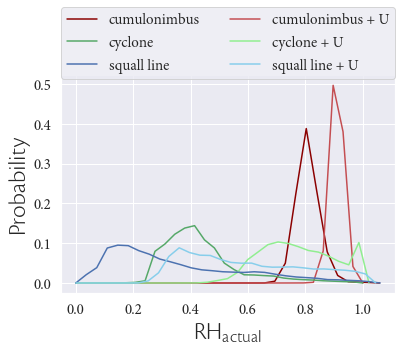

In [60]:
colorlist = np.asarray(['darkred', 'r', 'g', 'lightgreen', 'b', 'skyblue'], dtype=object)
labelslist = np.asarray(['cumulonimbus', 'cumulonimbus + U', 'cyclone', 'cyclone + U', 'squall line', 'squall line + U'], dtype=object)
Rhnlist = np.reshape(Rhlist, 6)
for i in np.arange(len(Rhnlist)):
    Rhhist = np.asarray(np.histogram(Rhnlist[i], density=True, bins=nbins), dtype=object)
    Rhdistrib = sp.rv_histogram(Rhhist)
    Rhxaxis = np.linspace(0,np.max(Rhnlist[i]),nbins)
    plt.plot(Rhxaxis, Rhdistrib.pdf(Rhxaxis)/np.sum(Rhdistrib.pdf(Rhxaxis)), color=colorlist[i], label=labelslist[i])
plt.xlabel('$\mathdefault{RH_{actual}}$', fontproperties=Cslabelprop)
plt.ylabel('Probability', fontproperties=Cslabelprop)
plt.xticks(font = Mplabelprop)
plt.yticks(font = Mplabelprop)
handles,labels = plt.gca().get_legend_handles_labels()
handles2 = [None] * 6
labels2 = [None] * 6
handles2[0] = handles[0]
handles2[1] = handles[2]
handles2[2] = handles[4]
handles2[3] = handles[1]
handles2[4] = handles[3]
handles2[5] = handles[5]
labels2[0] = labels[0]
labels2[1] = labels[2]
labels2[2] = labels[4]
labels2[3] = labels[1]
labels2[4] = labels[3]
labels2[5] = labels[5]
plt.legend(handles2, labels2, loc="upper center", bbox_to_anchor=(0.5, 1.35), ncol=2, prop=Mplabelprop)
plt.savefig('Figs/RHaProbsSuperposition.png',bbox_inches='tight', format='PNG', dpi=600)
plt.show()

# Step 3: Computing the predicted humidity

We now want to compute the predicted humidity at 5km, which is:
$$
RH = \frac{q_{sat}(z_{cloud})}{q_{sat}(z_{parcel})}
$$

We will try to calculate explicitely $RH_{predicted}$ in the following section. To do so, we first need to extract the index of $z_{clouds}$ values in $z$ array.

In [28]:
izclouds = lsa[1].astype(int)
izclouds2 = lsa2[1].astype(int)
izclouds3 = lsa3[1].astype(int)
izclouds4 = lsa4[1].astype(int)
izclouds5 = lsa5[1].astype(int)
izclouds6 = lsa6[1].astype(int)

We build a new function for $RH_{predicted}$ based on the one computing $RH_{actual}$. $q_v(z_{parcel})$ is effectively replaced by $q_{sat}(z_{clouds})$.

In [29]:
@njit
def RELHUMP(T,X,Y,Z,QSAT,iZclouds):
    RHP = np.empty( (len(T),len(X),len(Y)) )
    RHP[:,:,:] = np.nan
    for time in np.arange(len(T)):
        for i in np.arange(len(X)):
            for j in np.arange(len(Y)):
                RHP[time,i,j] = QSAT[time, iZclouds[time,i,j] ,j,i]/QSAT[time,Zparcel(Z)[0],j,i]
    return RHP

In [30]:
data.variables['QSAT']

<class 'netCDF4._netCDF4.Variable'>
float32 QSAT(time, z, y, x)
    long_name: Saturation specific humidity                                                    
    units: g/kg      
unlimited dimensions: time
current shape = (10, 68, 128, 128)
filling on, default _FillValue of 9.969209968386869e+36 used

In [31]:
RHp = RELHUMP(t,x,y,z,qsat,izclouds) 
RHp2 = RELHUMP(t2,x2,y2,z2,qsat2,izclouds2)
RHp3 = RELHUMP(t3,x3,y3,z3,qsat3,izclouds3)
RHp4 = RELHUMP(t4,x4,y4,z4,qsat4,izclouds4)
RHp5 = RELHUMP(t5,x5,y5,z5,qsat5,izclouds5)
RHp6 = RELHUMP(t6,x6,y6,z6,qsat6,izclouds6)

RHplist = np.asarray([RHp.flatten(), RHp2.flatten(), RHp3.flatten(), RHp4.flatten(), RHp5.flatten(), RHp6.flatten()])

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [32]:
RHp6.flatten().shape

(163840,)

**Debugging**  
- There were unphysical values in $RHp_i$ distributions, in particular values of $RH > 0$. *fixed*
- There are too many $RHp_i \sim 0 ~ \rightarrow$ This was due to wrong indentation function \texttt{RELHUM}. *fixed*  
- The peak of cumulonimbus distributions seems low.

In [53]:
RHpvszcloudslist = np.array([zcloudslist.flatten()/1000, RHplist])
vslabelslist = np.array(['$\mathdefault{z_{clouds}}$', '$\mathdefault{RH_{predicted}}$'])
limits = np.array([[4.7,20],[0, np.max(RHplist[3])]])

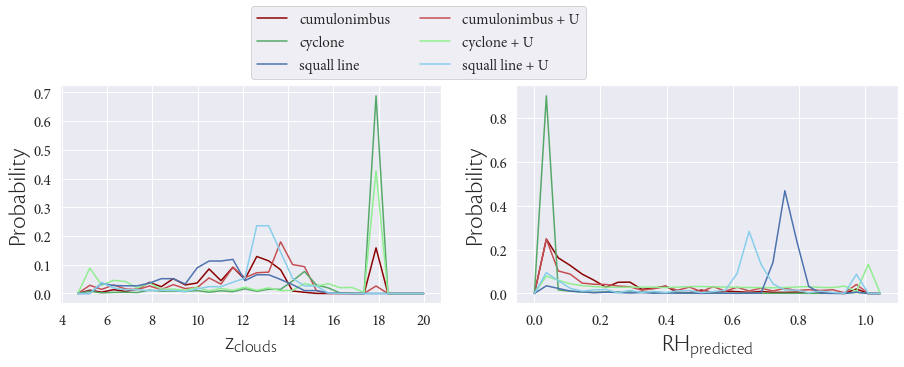

In [84]:
fig, ax = plt.subplots(1,2, figsize = (15,4))
for i in np.arange(len(RHpvszcloudslist)):
    for j in np.arange(len(zcloudslist.flatten())):
        hist = np.asarray(np.histogram(RHpvszcloudslist[i,j], density=True, bins=nbins), dtype=object)
        distrib = sp.rv_histogram(hist)
        xaxis = np.linspace(limits[i][0],limits[i][1],nbins)
        ax[i].plot(xaxis, distrib.pdf(xaxis)/np.sum(distrib.pdf(xaxis)), color=colorlist[j], label=labelslist[j])
    ax[i].set_xlabel(vslabelslist[i], fontproperties=Cslabelprop)
    ax[i].set_ylabel('Probability', fontproperties=Cslabelprop)
    for tick in ax[i].get_xticklabels():
        tick.set_fontname("Minion Pro")
        tick.set_fontsize(15)
    for tick in ax[i].get_yticklabels():
        tick.set_fontname("Minion Pro")
        tick.set_fontsize(15)
plt.legend(handles2,labels2,bbox_to_anchor=(0.2, 1.4), ncol=2, prop=Mplabelprop)
plt.savefig('Figs/zcloudsvsRHp.png', bbox_inches='tight', format='PNG', dpi=600)
plt.show()

In [90]:
RHpvsRh = np.array([Rhnlist, RHplist])
vslabelslistRHRh = ['$\mathdefault{RH_{actual}}$','$\mathdefault{RH_{predicted}}$']

In [91]:
RHpvsRh.shape

(2, 6)

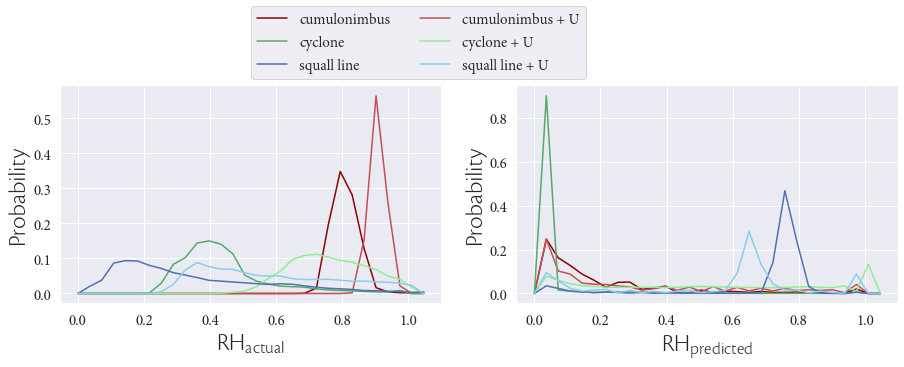

In [92]:
fig, ax = plt.subplots(1,2, figsize = (15,4))
for i in np.arange(len(RHpvsRh)):
    for j in np.arange(len(zcloudslist.flatten())):
        hist = np.asarray(np.histogram(RHpvsRh[i,j], density=True, bins=nbins), dtype=object)
        distrib = sp.rv_histogram(hist)
        xaxis = np.linspace(limits[1][0],limits[1][1],nbins)
        ax[i].plot(xaxis, distrib.pdf(xaxis)/np.sum(distrib.pdf(xaxis)), color=colorlist[j], label=labelslist[j])
    ax[i].set_xlabel(vslabelslistRHRh[i], fontproperties=Cslabelprop)
    ax[i].set_ylabel('Probability', fontproperties=Cslabelprop)
    for tick in ax[i].get_xticklabels():
        tick.set_fontname("Minion Pro")
        tick.set_fontsize(15)
    for tick in ax[i].get_yticklabels():
        tick.set_fontname("Minion Pro")
        tick.set_fontsize(15)
plt.legend(handles2,labels2,bbox_to_anchor=(0.2, 1.4), ncol=2, prop=Mplabelprop)
plt.savefig('Figs/RhvsRHp.png', bbox_inches='tight', format='PNG', dpi=600)
plt.show()

## This yields a different result, but it seems the humidity cannot be predicted by $q_{sat}(z_{clouds})$ as it is presently done

# Step 5: Taking into account atmospheric subsidence  

<img src="Figs/lastsaturationsubsidence.svg" width="700" height="450">

To make our model more realistic, we want to take into account the fact that air parcels move with finite speed through the environment. This speed is given by the atmospheric subsidence $w_{env}$. Suppose we have $N$ CRM simulations of atmospheric cloud states with corresponding times $t_i$, $i \in [1,N]$. Assuming those states are regularly separated by a time step $\Delta t$, the vertical distance covered by a moving parcel between two states will be   
$$
\Delta z = w_{env}\Delta t
$$
Being interested by the last saturation altitude of an air parcel located in the troposphere ($z_{parcel}$ ~ 5km) at time $t_N$, we can only look for clouds in the interval $[z_{parcel}; z_{parcel} + \Delta z]$ at $t_N$, because this is the maximum distance the parcel can cover between $t_N$ and $t_{N-1}$.  

Now, let's assume no clouds are found at $t_N$ between $z_{parcel}$ and $z_{parcel} + \Delta z$. We can still find the altitude of last saturation of the parcel, by looking at earlier times. Every step backwards in time elevates the parcel by $\Delta z$ in the atmosphere. The distance covered between $t_{N-2}$ and $t_N$ is therefore $2\Delta z$. This can be generalised to find the maximum value of $z_{clouds}$ (altitude above the parcel) as a function of atmospheric cloud state $i$
$$
\Delta z_i = (N-i+1) w_{env}\Delta t
$$
We could therefore find our new $z_{clouds}$ by making minor tweaks to our previous method. The process could be to compute all the lowest altitudes of clouds above $z_{parcel}$ = 5 km for an increasing range of $z$ values as we go back in time. For example, at $t_N$ we could only search in the range $[z_{parcel}; z_{parcel} + \Delta z]$, at $t_{N-1}$ in the range $[z_{parcel}; z_{parcel} + 2\Delta z]$, etc.. Then, the actual $z_{clouds}$ corresponding to the last saturation would be found by taking the lowest altitudes of clouds above the parcel at the highest $i$.

**Potential problems with this apporach**  

<img src="Figs/problems.svg" width="500" height="400"> 

Setting $\Delta t$ small enough should solve these issues in two ways:  
- It prevents the parcel from travelling large distances between $t_i$ and $t_{i+1}$ and miss some cloudy regions  
- It makes the clouds move slow enough so that from one $t_i$ to the next, cloudy regions cannot appear between the different parcel altitudes at $t_i$ and $t_{i+1}$

## Calculation of $w_{tot}$  

We are provided with vertical velocity $w$ at every coordinate, and are interested in the velocity of parcels outside clouds. Some simulations have an additional vertical velocity component $w{LS}$ which represent a large scale updraft. For simulations with no updraft, $w_{LS} = 0$ everywhere therefore the total vertical velocity outside convection is 
$$
w_{tot} = w_{env} + w_{LS}
$$

We first need to calculate $w_{env}$, which is the subsidence speed in the environment. To simplify future calculations we might want to take this as a constant over the domain and so average it over the whole grid instead of assigning one $w_{env}$ value to each grid point. Thus, we can compute 
$$
\bar{w}_{env} = \left.\bar{w}\right|_{q_i+q_c<10^{-6}}
$$
which is the mean vertical speed of air outside clouds.

*Getting the data*

In [35]:
print(data.variables['W'])

<class 'netCDF4._netCDF4.Variable'>
float32 W(time, z, y, x)
    long_name: Z Wind Component                                                                
    units: m/s       
unlimited dimensions: time
current shape = (10, 68, 128, 128)
filling on, default _FillValue of 9.969209968386869e+36 used
<ipython-input-35-175fce97c65e>:1: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  print(data.variables['W'])


In [36]:
w = data.variables['W'][:]
w2 = data2.variables['W'][:]
w3 = data3.variables['W'][:]
w4 = data4.variables['W'][:]
w5 = data5.variables['W'][:]
w6 = data6.variables['W'][:]

The function $\texttt{MWENV}$ computes the sum of mixing ratios $q_c$ and $q_i$ at every grid point and time step. It then appends the value of $w$ at this coordinate if the grid point is not in a cloud $(q_c + q_i < 1 \times 10^{-6})$. If the grid point is in a cloud, the value appended is a $\texttt{NaN}$. We then compute $\bar{w}_{env}$ by averaging $w_{env}$ over all non-$\texttt{NaN}$ values.

In [37]:
@njit
def MWENV(T,X,Y,Z,W,QC,QI):
    thresh = 1e-6
    Wenv = np.zeros(W.shape)
    for time in np.arange(len(T)):
        for i in np.arange(len(X)):
            for j in np.arange(len(Y)):
                for k in np.arange(len(Z)):
                    cond2 = QC[time,k,j,i] + QI[time,k,j,i]
                    if cond2<thresh:
                        Wenv[time,k,j,i] = W[time,k,j,i]
                    else:
                        Wenv[time,k,j,i] = np.nan
    return Wenv

In [38]:
mwenv = np.nanmean(MWENV(t,x,y,z,w,qc,qi), axis=(0,2,3))
mwenv2 = np.nanmean(MWENV(t2,x2,y2,z2,w2,qc2,qi2), axis=(0,2,3))
mwenv3 = np.nanmean(MWENV(t3,x3,y3,z3,w3,qc3,qi3), axis=(0,2,3))
mwenv4 = np.nanmean(MWENV(t4,x4,y4,z4,w4,qc4,qi4), axis=(0,2,3))
mwenv5 = np.nanmean(MWENV(t5,x5,y5,z5,w5,qc5,qi5), axis=(0,2,3))
mwenv6 = np.nanmean(MWENV(t6,x6,y6,z6,w6,qc6,qi6), axis=(0,2,3))

We find a $\bar{w}_{env}$ for each simulation. The three experiments without atmospheric ascendance have $\bar{w}_{env}$ superior to their counterparts. This means that the average downward speed in the environment is higher when there is ascendance.

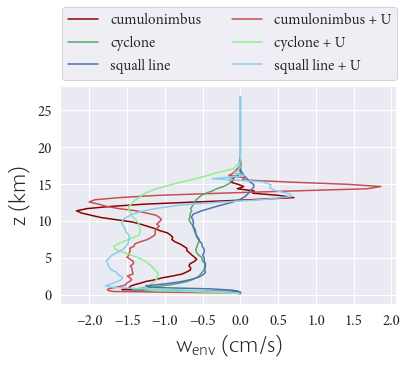

In [107]:
mwenvlist = [mwenv, mwenv2, mwenv3, mwenv4, mwenv5, mwenv6]
for i in np.arange(len(mwenvlist)):
    plt.plot(mwenvlist[i]*100, zlist[i]/1000, color=colorlist[i], label=labelslist[i])
plt.xlabel(r'$\mathdefault{w_{env}}$ (cm/s)', fontproperties=Cslabelprop)
plt.ylabel('$\mathdefault{z}$ (km)', fontproperties=Cslabelprop)
plt.xticks(font=Mplabelprop)
plt.yticks(font=Mplabelprop)
plt.legend(handles2,labels2,bbox_to_anchor=(1.025, 1.4), ncol=2, prop=Mplabelprop)
plt.savefig('Figs/wenvz.png',bbox_inches='tight', format='PNG', dpi=600)
plt.show()

As stated previously the total velocity of a parcel moving in the environment is not $\bar{w}_{env}$ for every simulations, because half of them have an imposed large scale velocity $w_{LS}$ at every $z$. To accurately compute the velocity of a parcel moving outside convective clouds we need to compute 
$$
\bar{w}_{tot} = \bar{w}_{env} + w_{LS}
$$
where the bars denote an average over the horizontal grid points. Note that $w_{LS}$ is already defined to be horizontally constant.

The calculation of $w_{LS}$ was made using a prewritten .f90 file that was translated by hand to python. A $\texttt{.h}$ file containing useful physical constants has also been translated and is used in the following cell.

In [40]:
%run const_thermo.py

SST = 30
p1 = 1000
pvzero = 100
H = 10
pmax = 500

Here we pull data from the .netCDF file yet again to get the pressure as a function of altitude $\texttt{p(z)}$. Where easily doable, parameters where defined using loops.

In [41]:
p = data.variables['p'][:]
p2 = data2.variables['p'][:]
p3 = data3.variables['p'][:]
p4 = data4.variables['p'][:]
p5 = data5.variables['p'][:]
p6 = data6.variables['p'][:]

plist = [p,p2,p3,p4,p5,p6]
nzlist = []
nz = len(p)
nzlist.append(nz)
for i in np.arange(2,7):
    locals()["nz"+str(i)] = len(plist[i-1])
    nzlist.append(locals()["nz"+str(i)])

omegamaxlist = []
omegamax = 0
omegamaxlist.append(omegamax)
for i in np.arange(2,7):
    if i % 2 == 0:
        locals()["omegamax" + str(i)] = -60
        omegamaxlist.append(locals()["omegamax" + str(i)])
    else:
        locals()["omegamax" + str(i)] = 0
        omegamaxlist.append(locals()["omegamax" + str(i)])

### Translation of fortran function for $w_{ls}$

In [42]:
def WLS(NZ,P,PMAX,OMEGAMAX):
    vmaxu=OMEGAMAX/86400*100.0
    pvmaxu=PMAX*100.0
    p1u=p1*100.0
    pvzerou=pvzero*100.0 
    omeLS = np.zeros((NZ))
    wLS = np.zeros((NZ))
    for i in np.arange(NZ):
        plevu = P[i]*100
        xm = p1u - pvmaxu
        xtw = p1u - pvzerou
        Asb=-vmaxu*(3.*xm-2.*xtw)/(xm*(xtw-xm)**2)
        Bsb=-vmaxu*(xtw-2.*xm)/(xm*xm*(xtw-xm)**2)
        xsb=p1u-plevu
        omeu=(xtw-xsb)*(Asb*xsb+Bsb*xsb*xsb)

        if plevu < pvzerou:
            omeu = 0 
        if omeu*OMEGAMAX < 0:
            omeu = 0
        
        ratio=(plevu+1e-10)/p1u
        zloc=-H*np.log(ratio)
        T=SST+degK-7.0*zloc/1000.0
        rho=plevu/Rd/T
        omeLS[i]=omeu*86400.0/100.0
        wLS[i]=-omeu/rho/g
    return wLS, omeLS

Below we use the same looping process to generate the 6 $w_{LS}$ from the function.

In [43]:
wLSlist = []
wLS = WLS(nz,p,pmax,omegamax)[0]
wLSlist.append(wLS)
for i in np.arange(2,7):
    locals()["wLS"+str(i)] = WLS(nzlist[i-1],plist[i-1],pmax,omegamaxlist[i-1])[0]
    wLSlist.append(locals()["wLS"+str(i)])
wLSlist = np.asarray(wLSlist, dtype=object)

As the imposed large scale vertical updraft was the same for affected simulations, we only plot 2 cases: one with the large scale updraft and one without

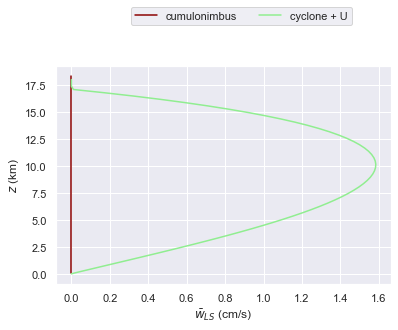

In [44]:
for i in np.arange(4,step=3):
    plt.plot(wLSlist[i]*100, zlist[i]/1000, color=colorlist[i], label=labelslist[i])
plt.xlabel(r'$\bar{w}_{LS}$ (cm/s)')
plt.ylabel('$z$ (km)')
plt.legend(bbox_to_anchor=(0.9, 1.3), ncol=2)
plt.savefig('Figs/wLSz.png',bbox_inches='tight', format='PNG', dpi=600)
plt.show()

$\bar{w}_{tot}$ can now be computed for every simulation. Note that $\bar{w}_{tot} = \bar{w}_{env}$ for simulations without large scale updraft.

In [45]:
def WTOT(MWENV,WLS):
    wtot = np.zeros(len(WLS))
    for i in np.arange(len(wtot)):
        wtot[i] = MWENV[i]+WLS[i]
    return wtot

In [46]:
wtot = WTOT(mwenv, wLS)
wtot2 = WTOT(mwenv2, wLS2)
wtot3 = WTOT(mwenv3, wLS3)
wtot4 = WTOT(mwenv4, wLS4)
wtot5 = WTOT(mwenv5, wLS5)
wtot6 = WTOT(mwenv6, wLS6)

wtotlist = [wtot, wtot2, wtot3, wtot4, wtot5, wtot6]

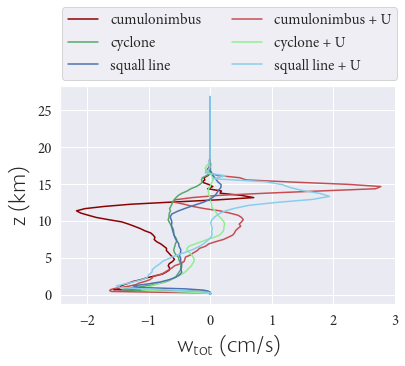

In [108]:
for i in np.arange(len(wtotlist)):
    plt.plot(wtotlist[i]*100, zlist[i]/1000, color=colorlist[i], label=labelslist[i])
plt.xlabel(r'$\mathdefault{w_{tot}}$ (cm/s)', fontproperties=Cslabelprop)
plt.ylabel('$\mathdefault{z}$ (km)', fontproperties=Cslabelprop)
plt.xticks(font=Mplabelprop)
plt.yticks(font=Mplabelprop)
plt.legend(handles2,labels2,bbox_to_anchor=(1.025, 1.4), ncol=2, prop=Mplabelprop)
plt.savefig('Figs/wtotz.png',bbox_inches='tight', format='PNG', dpi=600)
plt.show()

# A new set of data was used to continue the work. Please see the notebook $\texttt{RH_Trop.ipynb}$

In [48]:
zcloudso = zclouds
%store zcloudso
RHpo = RHp
%store RHpo

Stored 'zcloudso' (ndarray)
Stored 'RHpo' (ndarray)
